#### Trabajo Práctico N° 1
##### Resolución de sistemas lineales con descomposición LU
Facultad de Ciencias Exactas y Naturales

Álgebra Lineal Computacional 2°C 2023

Luca Jaichenco ~ 591/22 |Mario Sigal Aguirre ~ 157/22

In [1]:
# Imports
import numpy as np
import scipy
import time
import matplotlib.pyplot as plt

##### Creamos la funcion definir_matiz que genera una matiz n*n de números entre -1 y 1

In [2]:
def definir_matriz(shape):
    return np.random.uniform(-1,1, size=shape)

#### Ejercicio 1: descompLU
Dado $ A \in \mathbb{R}^{n \times n}$, la función __descompLU__ calcula la descomposición $LU$ de $A$. 

Se utiliza un algoritmo que realiza la descomposición por bloques de forma recursiva, teniendo en cuenta el siguiente planteamiento:
$$
A = LU
$$
$$
\begin{pmatrix}
        a_{11} & A_{12} \\
        A_{21} & A_{22}
    \end{pmatrix}
=
\begin{pmatrix}
        1 & 0  \\
        L_{21} & L_{22} 
    \end{pmatrix}
\cdot
\begin{pmatrix}
        u_{11} & U_{12}  \\
        0 & U_{22}
    \end{pmatrix}
$$

$$
\begin{pmatrix}
        a_{11} & A_{12} \\
        A_{21} & A_{22}
    \end{pmatrix}
=
\begin{pmatrix}
        u_{11} & U_{12}  \\
        L_{21}u_{11} & L_{21}U_{12} + L_{22}U_{22} 
    \end{pmatrix}
$$
Se plantean las siguientes ecuaciones para obtener el contenido de los bloques.

$$
u_{11} = a_{11}\\

U_{12} = A_{12}\\

L_{21} = \frac{A_{21}}{u_{11}}\\

L_{22}U_{22} = A_{22} - L_{21}U_{12}
$$

Para obtener $L_{22}$ y $U_{22}$ se calcula recursivamente la descomposición $LU$ del producto $L_{22}U_{22}$.


El Algoritmo funciona siempre y cuando primer elemento de la diagonal de $A$ sea distinto de cero en cada paso de la recursion.
$$ a_{11} \neq 0 $$

En cazo contrario, la función devuelve a la matriz identidad $I_n$ y la matriz $A$ original.




In [4]:
def descompLU(A):
    n = A.shape[0]
    
    #Caso Base/Matriz de 1x1
    if n == 1:
        if A[0, 0] == 0:
            print("Error: La Matriz tiene un 0 en la diagonal.")
            return np.eye(1), A  # Devuelve la matriz identidad y A original
        else:
            return np.array([[1]]), A  # Matriz L es 1x1 con valor 1 y U es A original

    #Definiciones de bloques:
         
    a11 = A[0, 0] # Obs: Python guarda este valor como un float  
    A12 = A[0, 1:]
    A21 = A[1:, 0] # Obs: Python guarda este vector en formato horizontal
    A22 = A[1:, 1:]

    #Definiciones de matrices complementarias: 
    
    I = np.eye(n)  # Matriz identidad de nxn
    I22 = np.eye(n-1) # Matriz identidad menor
    L = I
    U = np.zeros((n, n))  # Matriz de ceros de nxn
    
    
    # Cálculos:
    
    # Calculamos u11 y U12
    if a11 == 0:
        print("Error: La Matriz tiene un 0 en la diagonal.")
        return L, A  # Devuelve la matriz identidad y A original
    
    u11 = a11
    U12 = A12
    
    # Calculamos L21
    L21 = A21 / u11
    
    
    # Calculamos L22 y U22 recursivamente
    L22U22 = A22 - L21.reshape(-1,1)@U12.reshape(1,-1)
    L22, U22 = descompLU(L22U22)
   
    #Verificaciones:
    
    # Verifica si debe devolver (I_n, A) o (L, U)
    # Dividimos los casos en si n == 2 y si n>2, pues en las matrices de 2x2, el bloque U22 siempre es igual a L22U22 y L22 es igual a la identiodad, el problema esta en que cuando n == 2 a su vez es necesario que U22 sea igual a 0 para que se interprete como una matriz singular y devuelva la identidad y la A original
    if  n == 2 and np.array_equal(U22, L22U22) and np.array_equal(L22, I22) and U22 == [[0.]]: 
        return L, A  # Devuelve la matriz identidad y A original
    if n>2 and np.array_equal(U22, L22U22) and np.array_equal(L22, I22): 
        return L, A  # Devuelve la matriz identidad y A original
    
    # Actualizaciones:
    
    # Actualizamos las matrices L y U
    L[1:, 0] = L21
    U[0, 0] = u11
    U[0, 1:] = U12

    # Actualizamos las matrices L y U con los bloques calculados recursivamente
    L[1:, 1:] = L22
    U[1:, 1:] = U22
    
    return L, U



#### Ejercicio 3: resolverLU
Dada una matriz $ A \in \mathbb{R}^{n \times n}$ y un vectoir $ b \in \mathbb{R}^{n} $, la funcion __resolverLU__ devuelve la solucion $x$ del sistema $Ax = b$ mediante la descomposicion $LU$ de $A$, resolviendo los sistemas $Ly = b$ y $Ux = y$.

Decidimos implementar la funcion de dos maneras distintas, una estando programanda directamente desde cero y otra usando la libreria __SciPy__. esto nos permitira analizar la eficiencia de ambas posteriormente.


In [5]:
#resolverLU sin SciPy
def resolverL(L, b): # resuelve el sistema de una matriz triangular inferior
    n = L.shape[1]
    y = np.zeros(n)
    for i in range(n):
        suma = np.dot(L[i, :i], y[:i]) #la suma de los productos de los elementos por debajo de la diagonal principal de L y los valores en el vector y (producto interno)
        y[i] = (b[i] - suma) / L[i, i]
    return y

def resolverU(U, y): #resuelve el sistema de una matriz triangular superior
    n = U.shape[1]
    x = np.zeros(n)
    for i in range(n - 1, -1, -1):
        suma = np.dot(U[i, i + 1:], x[i + 1:]) #la suma de los productos de los elementos por encima de la diagonal principal de U y los valores en el vector x (producto interno)
        x[i] = (y[i] - suma) / U[i, i]
    return x

def resolverLU(A,b): 
    # Calcula la descomposición LU
    L, U = descompLU(A)

    # Resuelve ambos sistemas:
    y = resolverL(L,b)
    x = resolverU(U,y)   
    return x

In [6]:
#resolverLU con SciPy
np.random.seed(1)
def resolverLUSP(A, b):
    # Calcula la descomposición LU
    L, U = descompLU(A)
    
    # Resuelve ambos sistemas:
    y = scipy.linalg.solve_triangular(L,b, lower = True)
    x = scipy.linalg.solve_triangular(U,y)
    return x

#### Ejercicio 4: Probar resolverLU y calcular el Error Relativo en Norma-2

La funcion __error_rel_n2__ calcula el Error Relativo en Norma-2 entre dos vectores usando funciones de la libreria __NumPy__.

In [7]:
def error_rel_n2(x, y):
    res = np.linalg.norm(x-y,ord=2)/np.linalg.norm(y,ord=2)
    return res

Definimos una matriz $A \in \mathbb{R}^{10 \times 10}$  y un vector $b \in \mathbb{R}^{10}$, ambos de numeros aleatorios en [-1,1),
para calcular el error relativo de norma-2:
$$ \frac{||Ax-b||_2}{||b||_2}.

In [25]:
# Definimos la matriz A y el vector b:
np.random.seed(1)
A = definir_matriz((5,5))
b = definir_matriz((1,5))[0]

# Calculamos la solción del sistema
x = resolverLU(A, b)

# Calculamos el error relativo en norma-2 y su logaritmo natural 
error = error_rel_n2(A@x, b)
logerror = np.log(error_rel_n2(A@x, b))

print("El error relativo en norma 2 entre \nAx = {} \ny b = {}\nes: \n{}.\n\nEl error expresado en escala logaritmica es:\n{} ".format(A@x, b, error, logerror))


El error relativo en norma 2 entre 
Ax = [ 0.78921333 -0.82991158 -0.92189043 -0.66033916  0.75628501] 
y b = [ 0.78921333 -0.82991158 -0.92189043 -0.66033916  0.75628501]
es: 
1.891508243839044e-15.

El error expresado en escala logaritmica es:
-33.90140187146865 


#### Ejercicio 5: Cálculo de la Inversa

La funcion __inversa__ recibe una matriz $A \in \mathbb{R}^{n \times n}$ inversible y calcula su inversa por medio de su descomposicion $LU$ y la resolucion de los sistemas $Ly = b$ y $Ux = y$, siendo y los vectores de la base canónica $e_i, 1 \leq i \leq n $ .

Al igual que en el ejercicio 3 Decidimos implementar la funcion de dos maneras distintas, una estando programanda directamente desde cero y otra usando la libreria __SciPy__. esto nos permitira analizar la eficiencia de ambas posteriormente.

In [8]:
#inversa sin SciPy
#copiamos de vuelta resolverU y resolverL para que las celdas del ejercicio 3 y ejercicio 5 se puedan correr independientemente una de otra
def resolverL(L, b): #resuelve el sistema de una matriz triangular Inferior
    n = L.shape[1]
    y = np.zeros(n)
    for i in range(n):
        suma = np.dot(L[i, :i], y[:i]) #la suma de los productos de los elementos por debajo de la diagonal principal de L y los valores en el vector y (producto interno)
        y[i] = (b[i] - suma) / L[i, i]
    return y

def resolverU(U, y): #resuelve el sistema de una matriz triangular superior
    n = U.shape[1]
    x = np.zeros(n)
    for i in range(n - 1, -1, -1):
        suma = np.dot(U[i, i + 1:], x[i + 1:]) #la suma de los productos de los elementos por encima de la diagonal principal de U y los valores en el vector x (producto interno)
        x[i] = (y[i] - suma) / U[i, i]
    return x

def inversa(A):
    
    # Calcula la descomposición LU :
    L, U = descompLU(A)
    
    # Se Definen otras matrices a utilizar:
    n = A.shape[0]
    Inv = np.zeros((n,n))
    
    # para cada vector columna de la matriz identidad: 
    for i in range(n):
        e_i = np.zeros(n)
        e_i[i] = 1  
        #Resuelve los sistemas:
        
        
        y = resolverL(L, e_i)
        x = resolverU(U, y)
        
        #incorpora los vectores obtenidos a la matriz inversa:
        Inv[0:, i]=x
        
    return Inv



In [9]:
#inversa con SciPy
def inversaSP(A):
    # Calculamos la descomposición LU
    L, U = descompLU(A)
    
    # Definimos la matriz identidad
    In = np.eye(A.shape[0])
    
    # resolvemos los sistemas para cada vector de la matriz identidad
    y = scipy.linalg.solve_triangular(L, In, lower = True)
    x = scipy.linalg.solve_triangular(U, y)
    return x


#### Ejercicio 6: Probar Inversa y calcular el error en norma Frobenius.
La funcion __error_nF__ calcula el error en norma Frobenius entre $A^{-1}A$ e $I$, siendo $A$ una matriz $\in \mathbb{R}^{n\times n}$ e $I$ la matriz identidad.

$$
|| A^{-1}A - I ||_{F}
$$
El resultado de esta expresión debería ser cercano a cero si la matriz $A$ es invertible y si la multiplicación $A^{-1} A$ se acerca a la matriz identidad.

Se calcula usando funciones de la libreria __NumPy__.

In [28]:
def error_nF(A):
    Ainv = inversa(A)
    res = np.linalg.norm(Ainv@A - np.eye(A.shape[0]), ord='fro')
    return res

Definimos una matriz $A \in \mathbb{R}^{10\times 10}$ y calculames el error en norma Frobenius entre $A^{-1}A$ e $I$

In [29]:
#Definimos A:
A = definir_matriz((10,10))
#Calculamos el error en norma Frobenius y su logaritmo natural
error_nf = error_nF(A)
logerror_nf = np.log(error_nf)

print("El error en norma Frobenius entre A^(-1).A e I es: \n{}.\nEl error expresado en escala logarítmica es:\n{} ".format(error_nf, logerror_nf))

El error en norma Frobenius entre A^(-1).A e I es: 
3.641164002202212e-13.
El error expresado en escala logaritmica es:
-28.64130279756815 


#### Ejercicio 7: Experimento 1
Realizaremos el experimento descripto en las consignas del Trabajo Practico:

Investigaremos si existe relación entre el tamaño de una matriz $A$ y el error que se comente al calcular la solución del sistema $Ax = b$ y analizaremos los siguientes casos:

Resolver el sistema $Ax = b$ mediante la resolución de los sistemas $Ly = b$ y $Ux = y$.

- usando la función resolverLU 

- usando la función resolverLUSP

Resolver el sistema $Ax = b$ mediante el calculo de la inversa de $A$, siendo $x = A^{-1}b $

- usando la función inversa
- usando la función inversaSP

A su vez nos interesa investigar los tiempos de ejecución de cada uno de los métodos, esto nos permitirá obtener una conclusión mas concisa y exacta.

Aclaraciones:
- Como el error relativo medido es muy cercano a cero, para una mejor visualización, calculamos la suma de los logaritmos naturales de los errores relativos de diez matrices distintas para cada rango de matrices entre 10 y 200

- El tiempo medido es el tiempo transcurrido entre el comienzo y el final del calculo del error relativo de las diez matrices en cada rango, por eso calculamos el tiempo promedio para cada matriz.


In [64]:
#Experimento 1: resolverLU
np.random.seed(1)# en cada uno de los 4 experimentos queremos usar las mismas matrices

v1 = np.zeros(200)
tiempo1 = np.zeros(200)
# Buscamos errores relativos para ResolverLU
for n in range(10, 201):
    suma_errores = 0
    start = time.time()
    for i in range(10):
        
        # Definimos la matriz A, x y b tal que Ax = b
        A = definir_matriz((n,n))
        x = definir_matriz((n,1))
        b = A@x
        
        # Resolvemos el sistema Ax = b y calculamos el error
        x1 = resolverLU(A,b)
        suma_errores += np.log(error_rel_n2((A@x1).reshape(-1,1),b))# el reshape es porque A@x1 devuelve un vector horizontal y b es una matriz de (n,1) (vector vertical)
    
    tiempo1[n-1] = (time.time() - start)/10 # es el promedio del tiempo para calcular una matriz
    v1[n-1] = suma_errores




C:\Users\mario\AppData\Local\Temp\ipykernel_12244\2930507936.py:35: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y[i] = (b[i] - suma) / L[i, i]


In [20]:
#Experimento 2: resolverLUSP
np.random.seed(1)# en cada uno de los 4 experimentos queremos usar las mismas matrices

v2 = np.zeros(200)
tiempo2 = np.zeros(200)

# Buscamos errores relativos para ResolverLUSP
for n in range(10, 201):
    suma_errores = 0
    start = time.time()
    for i in range(10):
        
        # Definimos la matriz A, x y b tal que Ax = b
        A = definir_matriz((n,n))
        x = definir_matriz((n,1))
        b = A@x
        
        # Resolvemos el sistema Ax = b y calculamos el error
        x2 = resolverLUSP(A,b)
        suma_errores += np.log(error_rel_n2(A@x2,b))

    tiempo2[n-1] = (time.time() - start)/10 # es el promedio del tiempo para calcular una matriz
    v2[n-1] = suma_errores


In [66]:
#Experimento 3: Inversa
np.random.seed(1)# en cada uno de los 4 experimentos queremos usar las mismas matrices
v3 = np.zeros(200)
tiempo3 = np.zeros(200)

# Buscamos errores relativos para ResolverLUSP
for n in range(10, 201):
    suma_errores = 0
    start = time.time()
    for i in range(10):
        
        # Definimos la matriz A, x y b tal que Ax = b
        A = definir_matriz((n,n))
        x = definir_matriz((n,1))
        b = A@x
        
        # Resolvemos el sistema Ax = b y calculamos el error
        x3 = inversa(A)@b
        suma_errores += np.log(error_rel_n2(A@x3,b))

    tiempo3[n-1] = (time.time() - start)/10 # es el promedio del tiempo para calcular una matriz
    v3[n-1] = suma_errores
#tarda aprox 2min 30 seg

In [21]:
#Experimento 4: InversaSP
np.random.seed(1)# en cada uno de los 4 experimentos queremos usar las mismas matrices
v4 = np.zeros(200)
tiempo4 = np.zeros(200)

# Buscamos errores relativos para ResolverLUSP
for n in range(10, 201):
    suma_errores = 0
    start = time.time()
    for i in range(10):
        
        # Definimos la matriz A, x y b tal que Ax = b
        A = definir_matriz((n,n))
        x = definir_matriz((n,1))
        b = A@x
        
        # Resolvemos el sistema Ax = b y calculamos el error
        x4 = inversaSP(A)@b
        suma_errores += np.log(error_rel_n2(A@x4,b))

    tiempo4[n-1] = (time.time() - start)/10 # es el promedio del tiempo para calcular una matriz
    v4[n-1] = suma_errores


KeyboardInterrupt: 

__Leyenda:__ El siguiente gráfico muestra la relación entre el error relativo y el tamaño de la matriz, midiendo el error relativo de norma 2 entre $Ax_1$ y la solución exacta $b$.

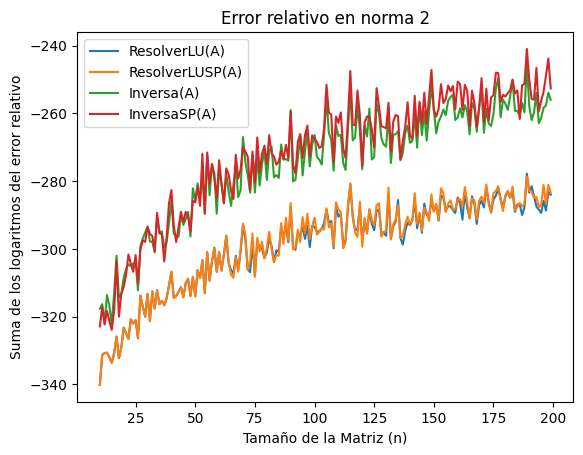

In [68]:

n = np.arange(10, len(v1))
plt.plot(n, v1[10:], label='ResolverLU(A)')
plt.plot(n, v2[10:], label='ResolverLUSP(A)')
plt.plot(n, v3[10:], label='Inversa(A)')
plt.plot(n, v4[10:], label='InversaSP(A)')

plt.xlabel('Tamaño de la Matriz (n)')
plt.ylabel('Suma de los logaritmos del error relativo')
plt.title('Error relativo en norma 2')

plt.legend()
plt.show()


__Observaciones:__
- El error que comenten las funciones __resolverLU__ y  __resolverLUSP__ es relativamente parecido. 
- El error que comenten las funciones __inversa__ e  __inversaSP__ es relativamente parecido.
- Hay una gran diferencia entre los errores relativos cometidos por el grupo de funciones __resolverLU__ y el grupo de funciones __inversa__. Siendo los errores del primer grupo mucho menores que los del segundo grupo.

__Leyenda:__ El siguiente gráfico muestra la relación entre el tiempo de ejecución y el tamaño de la matriz

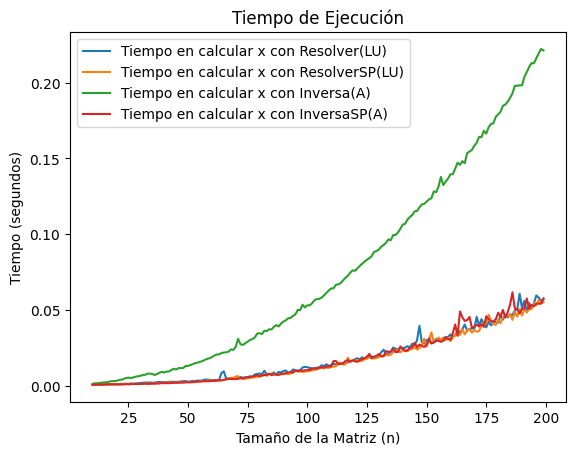

In [71]:
n = np.arange(10, len(tiempo1))
plt.plot(n, tiempo1[10:], label='Tiempo en calcular x con Resolver(LU)')
plt.plot(n, tiempo2[10:], label='Tiempo en calcular x con ResolverSP(LU)')
plt.plot(n, tiempo3[10:], label='Tiempo en calcular x con Inversa(A)')
plt.plot(n, tiempo4[10:], label='Tiempo en calcular x con InversaSP(A)')

plt.title('Tiempo de Ejecución')

plt.xlabel('Tamaño de la Matriz (n)')
plt.ylabel('Tiempo (segundos)')
plt.legend()

plt.show()

__Observaciones:__
- Los tiempos de ejecución de las funciones __resolverLU__, __resolverLUSP__ e __inversaSP__ son relativamente parecidos.
- El tiempo de ejecución de la función __inversa__ es mucho mayor que los de las otras funciones. Esto se debe a que en __inversaSP__ usamos la matriz identidad para calcular la inversa, a diferencia de __inversa__ que lo hace mediante un for recorriendo los vectores de la base canónica.

En conclusión, siempre que se trabaje de manera matricial, el tiempo de ejecución va a hacer considerablemente menor.

##### Decisiones:
- Dado los resultados del experimento 1 decidimos usar a partir de este momento solamente las funciones __resolverLUSP__ e __inversaSP__ debido a su menor tiempo de ejecución y similar error relativo.

---
#### Ejercicio 8: Experimento 2
Repetimos el procedimiento realizado en el ejercicio 7, pero esta vez calculando el error relativo en norma 2 entre las soluciones halladas y la solución original.
$$ \frac{|| x_{i} - x ||_{2}}{||x||_{2}} $$
Lo haremos unicamente para/con las funciones __resolverLUSP__ e __inversaSP__


In [14]:
np.random.seed(1)
v5 = np.zeros(200)
v6 = np.zeros(200)

# Buscamos errores relativos para ResolverLU
for n in range(10, 201):
    
    suma_errores_res = 0
    suma_errores_inv = 0
    
    for i in range(10):
        # Definimos la matriz A, x y b tal que Ax = b
        A = definir_matriz((n,n))
        x = definir_matriz((n,1))
        b = A@x

        # Resolvemos el sistema Ax = b con resolverLUSP y calculamos el error 
        x1 = resolverLUSP(A,b)
        suma_errores_res += np.log(error_rel_n2(x1,x))

        # Resolvemos el sistema Ax = b con inversaSP y calculamos el error
        x2 = inversaSP(A)@b
        suma_errores_inv += np.log(error_rel_n2(x2,x))
        
    v5[n-1] = suma_errores_res
    v6[n-1] = suma_errores_inv

__Leyenda__: El siguiente gráfico muestra la relación entre el error relativo y el tamaño de la matriz, midiendo el error relativo en norma 2 entre las soluciones halladas y la solución original.

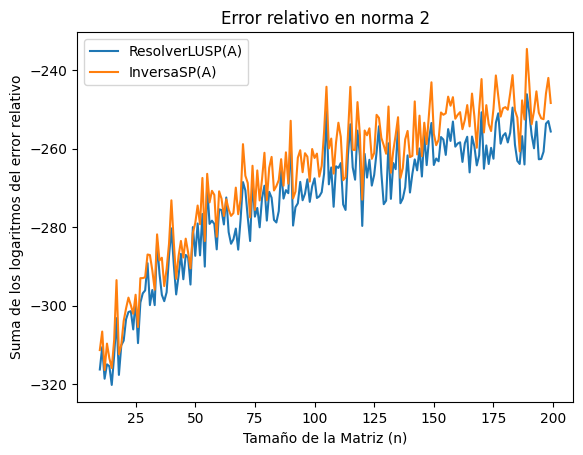

In [16]:
n = np.arange(10, len(v5))
plt.plot(n, v5[10:], label='ResolverLUSP(A)')
plt.plot(n, v6[10:], label='InversaSP(A)')

plt.xlabel('Tamaño de la Matriz (n)')
plt.ylabel('Suma de los logaritmos del error relativo')
plt.title('Error relativo en norma 2')

plt.legend()
plt.show()


Observaciones:
- El comportamiento de los errores relativos es similar al del experimento 1, pero esta vez el error de __ResolverLUSP__ es algo mayor.

---
#### Ejercicio 9: Experimento 3
Realizamos los mismos experimentos, esta vez utilizando las funciones de numpy __numpy.linalg.solve__ y __numpy.linalg.inv__.

Empezamos con el Ejercicio 7

In [17]:
#Experimento 1: numpy.linalg.solve
np.random.seed(1)# en cada uno de los 4 experimentos queremos usar las mismas matrices

v7 = np.zeros(200)
tiempo7 = np.zeros(200)

# Buscamos errores relativos para ResolverLUSP
for n in range(10, 201):
    suma_errores = 0
    start = time.time()
    for i in range(10):
        
        # Definimos la matriz A, x y b tal que Ax = b
        A = definir_matriz((n,n))
        x = definir_matriz((n,1))
        b = A@x
        
        # Resolvemos el sistema Ax = b y calculamos el error
        x1 = np.linalg.solve(A,b)
        suma_errores += np.log(error_rel_n2(A@x1,b))

    tiempo7[n-1] = (time.time() - start)/10 # es el promedio del tiempo para calcular una matriz
    v7[n-1] = suma_errores

In [18]:
#Experimento 2: scipy.linalg.solve
np.random.seed(1)# en cada uno de los 4 experimentos queremos usar las mismas matrices
v8 = np.zeros(200)
tiempo8 = np.zeros(200)

# Buscamos errores relativos para ResolverLUSP
for n in range(10, 201):
    suma_errores = 0
    start = time.time()
    for i in range(10):
        
        # Definimos la matriz A, x y b tal que Ax = b
        A = definir_matriz((n,n))
        x = definir_matriz((n,1))
        b = A@x
        
        # Resolvemos el sistema Ax = b y calculamos el error
        x2 = np.linalg.inv(A)@b
        suma_errores += np.log(error_rel_n2(A@x2,b))

    tiempo8[n-1] = (time.time() - start)/10 # es el promedio del tiempo para calcular una matriz
    v8[n-1] = suma_errores


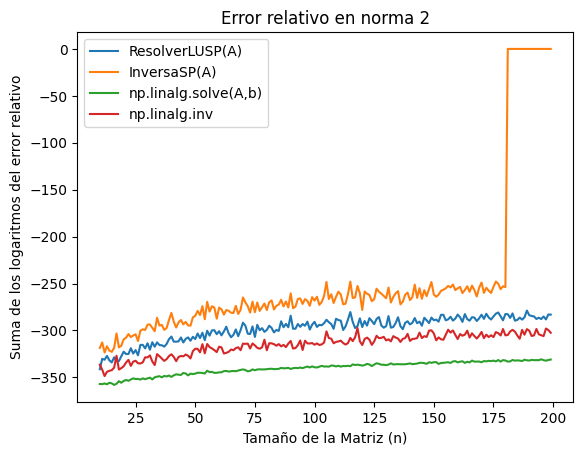

In [27]:
n = np.arange(10, len(v2))
plt.plot(n, v2[10:], label='ResolverLUSP(A)')
plt.plot(n, v4[10:], label='InversaSP(A)')
plt.plot(n, v7[10:], label='np.linalg.solve(A,b)')
plt.plot(n, v8[10:], label='np.linalg.inv')

plt.xlabel('Tamaño de la Matriz (n)')
plt.ylabel('Suma de los logaritmos del error relativo')
plt.title('Error relativo en norma 2')

plt.legend()
plt.show()


Observaciones:
- Los errores de las funciones de numpy son mucho menores que los errores de nuestras funciones.
- En ambos casos, calcular la inversa genera más error que resolver el sistema mediante la descomposición LU.

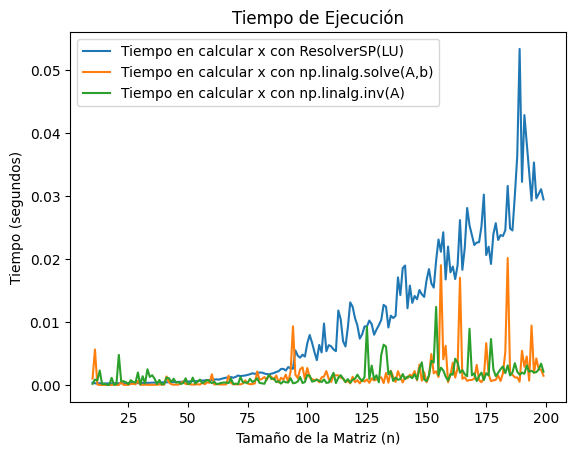

In [25]:
n = np.arange(10, len(tiempo2))
plt.plot(n, tiempo2[10:], label='Tiempo en calcular x con ResolverSP(LU)')
plt.plot(n, tiempo4[10:], label='Tiempo en calcular x con InversaSP(A)')
plt.plot(n, tiempo7[10:], label='Tiempo en calcular x con np.linalg.solve(A,b)')
plt.plot(n, tiempo8[10:], label='Tiempo en calcular x con np.linalg.inv(A)')

plt.title('Tiempo de Ejecución')

plt.xlabel('Tamaño de la Matriz (n)')
plt.ylabel('Tiempo (segundos)')
plt.legend()

plt.show()

Observaciones:
- Los tiempos de ejecución de las funciones de numpy son mucho menores que los tiempos de ejecución de nuestras funciones.
- Las funciones de numpy mantienen un tiempo de ejecución constante, mientras que nuestras funciones aumentan su tiempo de ejecución a medida que aumenta el tamaño de la matriz.

Ahora volvemos a realizar el Ejercicio 8.

In [28]:
np.random.seed(1)
v10 = np.zeros(200)
v11 = np.zeros(200)

# Buscamos errores relativos para ResolverLU
for n in range(10, 201):
    
    suma_errores_res = 0
    suma_errores_inv = 0
    
    for i in range(10):
        # Definimos la matriz A, x y b tal que Ax = b
        A = definir_matriz((n,n))
        x = definir_matriz((n,1))
        b = A@x

        # Resolvemos el sistema Ax = b con resolverLUSP y calculamos el error 
        x1 = np.linalg.solve(A,b)
        suma_errores_res += np.log(error_rel_n2(x1,x))

        # Resolvemos el sistema Ax = b con inversaSP y calculamos el error
        x2 = np.linalg.inv(A)@b
        suma_errores_inv += np.log(error_rel_n2(x2,x))
        
    v10[n-1] = suma_errores_res
    v11[n-1] = suma_errores_inv

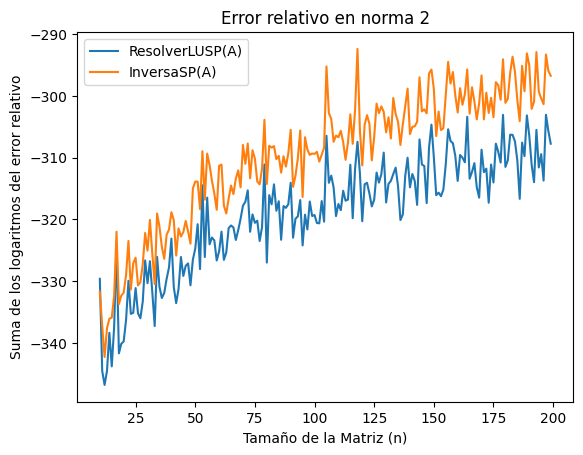

In [30]:
n = np.arange(10, len(v5))
plt.plot(n, v10[10:], label='ResolverLUSP(A)')
plt.plot(n, v11[10:], label='InversaSP(A)')

plt.xlabel('Tamaño de la Matriz (n)')
plt.ylabel('Suma de los logaritmos del error relativo')
plt.title('Error relativo en norma 2')

plt.legend()
plt.show()

Observaciones:
- Las funciones de numpy tienen un error relativo menor que nuestras funciones comparado a lo calculado en el ejercicio 8.
- Mantienen un comportamiento similar entre ellas. 

---
#### Ejercicio 10: Experimento 4

El ejercicio pide que realizemos el mismo experimento que en el ejercicio 7, pero esta vez con matrices de Hilbert.
$$H_n=
\begin{pmatrix}
1 & \frac{1}{2} & \frac{1}{3} & \cdots  & \frac{1}{n}\\
\frac{1}{2} & \frac{1}{3} & \frac{1}{4} & \cdots & \frac{1}{n+1} \\
\frac{1}{3} & \frac{1}{4} & \frac{1}{5} & \cdots & \frac{1}{n+2}\\
\vdots & \vdots & \vdots  & \ddots & \vdots\\
\frac{1}{n} & \frac{1}{n+1} & \frac{1}{n+2} & \cdots &  \frac{1}{2n-1}\\
\end{pmatrix}
$$

In [31]:
# Definimos la matriz de Hilbert
def hilbert(n):
    H = np.zeros((n,n))
    for i in range(n):
        for j in range(n):
            H[i,j] = 1/(i+j+1)
    return H

In [52]:
#Experimento 2: resolverLUSP
np.random.seed(1)# en cada uno de los 4 experimentos queremos usar las mismas matrices

v12 = np.zeros(20)
tiempo12 = np.zeros(20)

# Buscamos errores relativos para ResolverLUSP
for n in range(2, 21): # de 2 a 20
    suma_errores = 0
    start = time.time()
    for i in range(10):
        
        # Definimos la matriz A, x y b tal que Ax = b
        A = hilbert(n) # Usamos la matriz de Hilbert
        x = definir_matriz((n,1))
        b = A@x
        
        # Resolvemos el sistema Ax = b y calculamos el error
        x1 = resolverLUSP(A,b)
        suma_errores += np.log(error_rel_n2(A@x1,b))

    tiempo12[n-1] = (time.time() - start)/10 # es el promedio del tiempo para calcular una matriz
    v12[n-1] = suma_errores


/var/folders/7g/ls35h7x11hdg1yjtzhxk2z9w0000gn/T/ipykernel_58657/214717100.py:20: RuntimeWarning: divide by zero encountered in log
  suma_errores += np.log(error_rel_n2(A@x1,b))


In [58]:
#Experimento 4: InversaSP
np.random.seed(1)# en cada uno de los experimentos queremos usar las mismas matrices
v13 = np.zeros(20)
tiempo13 = np.zeros(20)
numcond = np.zeros(20)

# Buscamos errores relativos para ResolverLUSP
for n in range(2, 21): # de 2 a 20
    suma_errores = 0
    start = time.time()
    for i in range(10):
        
        # Definimos la matriz A, x y b tal que Ax = b
        A = hilbert(n) # Usamos la matriz de Hilbert
        numcond[n-1] = np.linalg.cond(A)
        x = definir_matriz((n,1))
        b = A@x
        
        # Resolvemos el sistema Ax = b y calculamos el error
        x2 = inversaSP(A)@b
        suma_errores += np.log(error_rel_n2(A@x2,b))

    tiempo13[n-1] = (time.time() - start)/10 # es el promedio del tiempo para calcular una matriz
    v13[n-1] = suma_errores

/var/folders/7g/ls35h7x11hdg1yjtzhxk2z9w0000gn/T/ipykernel_58657/1991923608.py:21: RuntimeWarning: divide by zero encountered in log
  suma_errores += np.log(error_rel_n2(A@x2,b))


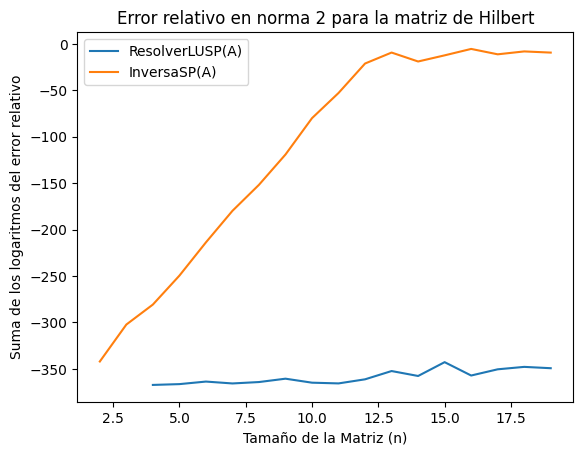

In [48]:
n = np.arange(2, len(v12))
plt.plot(n, v12[2:], label='ResolverLUSP(A)')
plt.plot(n, v13[2:], label='InversaSP(A)')

plt.xlabel('Tamaño de la Matriz (n)')
plt.ylabel('Suma de los logaritmos del error relativo')
plt.title('Error relativo en norma 2 para la matriz de Hilbert')

plt.legend()
plt.show()

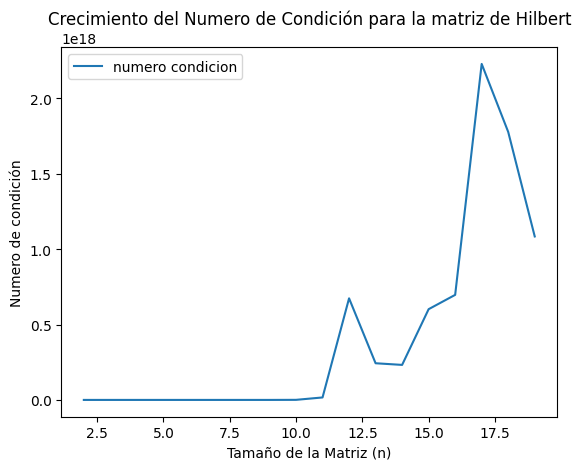

In [59]:
n = np.arange(2, len(numcond))
plt.plot(n, numcond[2:], label='numero condicion')

plt.xlabel('Tamaño de la Matriz (n)')
plt.ylabel('Numero de condición')
plt.title('Crecimiento del Numero de Condición para la matriz de Hilbert')

plt.legend()
plt.show()

Observaciones:
- El error relativo en la inversa va aumentando a medida que aumenta el tamaño de la matriz.
- El error relativo en la descomposición LU se mantiene constante a medida que aumenta el tamaño de la matriz.
- Los primeros valores del error relativo no se muestran ya que, al ser tan pequeños, la computadora los interpreta como cero y el logaritmo natural de cero no esta definido.
- El numero de condición crece mucho a medida que aumenta el tamaño de la matriz, lo que genera un error relativo mayor.

---

### Conclusiones Finales:

- Calcular la inversa de una matriz para resolver un sistema lineal es una manera menos eficiente y con mayor posible error que utilizar la descomposición LU, como vimos en el ejercicio 7.
- Hacer operaciones matriciales es mucho más eficiente que hacer operaciones con vectores en un ciclo, esto lo vimos en el ejercicio 7 al programar la función inversa.
- Usar funciones de librerias como numpy es mucho más eficiente que programarlas desde cero, como vimos en el ejercicio 9.
- A mayor numero de condición de la matriz, mayor error relativo se comete al resolver el sistema lineal, como vimos en el ejercicio 10.
- Al obtener errores muy cercanos a cero, se pueden tener problemas porque la computadora los interpreta como cero.
